# Lidar data × Python Tutorial Session 1. ～点群データことはじめ～

チュートリアルではPythonを使用してLidarのデータ処理について学んでいきます。第一回のこのセッションでは、Lidar計測データフォーマットの1つである`.las`を題材に、実際のPythonコードを実行しながら進んでいきましょう。
---

Section1.
 - 外部ライブラリのインストールと今回使用するライブラリのインポート

Section2.
 - データの読み込みとメタデータを確認する

 - データの範囲を確認する

 - 空間参照系の設定

 - データの保存

Section3.
 - データを眺める

おわりに.


# Section1.
このチュートリアルでは`C++`のライブラリである`PDAL(Point Data Abstraction Library)`を使用して点群データを処理していきます。以下は生成AIで作成したPDALについての要約です。

 - PDALは、LiDARデータを含む点群データを処理するためのオープンソースのライブラリおよびアプリケーションです。

 - GDALライブラリがラスターとベクターデータを処理するのと同様に、PDALは点群データを操作します。

 - PDALは、点群データの変換、フィルタリング、クエリ、結合などのさまざまな操作を行うことができます。


## 外部ライブラリーのインストール
---
点群データを扱う為のライブラリをインストールする必要があります。

 - <b>"Anaconda"を使用する場合</b>

    Anaconda環境を使用する場合は、別途用意された'.yaml'ファイルから、点群処理に必要なライブラリーがインストールされた仮想環境を作成して下さい。

 - <b>"Google Colabratory"を使用する場合</b>
    
    GoogleColabの環境を使用する場合は、以下のセル2つを実行し、点群処理に必要なライブラリーをインストールして下さい。こちらはNotebookを閉じると初期化されるので、毎回インストールが必要です。

In [1]:
# 最初にこのセルを実行すると、一度セッションが再起動される。再起動されたら、次のセルを実行してもよい。
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:20
🔁 Restarting kernel...


In [2]:
# 今回のチュートリアルに必要なライブラリをインストールする。
# これも実行すると再起動がかかるかもしれないが、その後下のセルを実行する事が出来る。
!conda update -y -n base -c defaluts conda
!conda install --channel conda-forge pdal
!pip install PDAL open3d polars japanize_matplotlib folium mapclassify pyproj

Channels:
 - defaluts
 - conda-forge
Platform: linux-64

UnavailableInvalidChannel: HTTP 404 NOT FOUND for channel defaluts <https://conda.anaconda.org/defaluts>

The channel is not accessible or is invalid.

You will need to adjust your conda configuration to proceed.
Use `conda config --show channels` to view your configuration's current state,
and use `conda config --show-sources` to view config file locations.


Channels:
 - conda-forge
Platform: linux-64
Solving environment: \ | / - \ | / done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.3.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - pdal


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    aws-c-auth-0.7.17          |       he0b1f16_2   

## ライブラリのインポートとGoogleDriveの接続
---
GoogleColabでは直接データをアップロードする事も可能ですが、処理時間が掛かります。今回は事前に自分のGoogleDriveに使用する`.las`ファイルとオルソ画像を保存しておき、そこから読み込んで使用しましょう。


In [56]:
import json
import os
from pprint import pprint

import geopandas as gpd
# from google.colab import drive
import japanize_matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pdal
import pyproj
import shapely
from shapely.plotting import plot_polygon

# GoogleDriveをマウント
# drive.mount('/content/drive')

# Section2.
このセクションでは`.las`ファイルにどんなデータが保存されているのかを見て見ましょう。`PDAL`は`CLI(Command Line Interface)`で操作するのが一般的だと思いますが、今回は`GoogleColab`を使用しているという事もあり、`Python`から呼び出して使用してみます。

処理する内容や順番は`pipeline`に記述します。`pipeline`ではデータの入出力や処理の流れを記述し、`.json`フォーマットのファイルに書き出し、それを読み込んで使用します。しかし面倒なので、今回はセルの中にDict型のオブジェクトとして変数に代入し、それを`json.dumps`モジュールでjson文字列化して使用しましょう。


## データの読み込みとメタデータの確認
---
まずは`pipeline`の第一歩としてデータの読み込みを行います。
`pipeline`の記述方法について、簡単にはセルの中にコメントを書いていますが、詳しくは公式のドキュメントを読んだ方がいいでしょう。

 - [PDAL Documents](https://pdal.io/en/2.7-maintenance/)

 - [Pipeline](https://pdal.io/en/2.7-maintenance/pipeline.html)


In [2]:
# GoogleDrive内にある`.las`ファイルまでのパス
# INPUT_FILE = r'/content/drive/MyDrive/notebooks/LearnLidar_JFF/Izu.las'
INPUT_FILE = r'./datasets/Izu.las'

# Pipeline処理をDict型のオブジェクトに記述する。
sentence = {
    'pipeline': [
        { # データを読み込む処理
            'type' : 'readers.las', # <- .の後はフォーマットを指定、今回は`las`
            'filename': INPUT_FILE # <- GoogleDrive内にある`.las`ファイルまでのパス
        }
    ]
}
# Dict型のオブジェクトをJSON文字列に変換
json_sentence = json.dumps(sentence)


# PipelineのクラスにJSON文字列を渡し、インスタンスを作成する。
pipeline = pdal.Pipeline(json_sentence)
# Pipeline処理の実行
pipeline.execute()


# `.las`に入力されているメタデータの取得と表示
meta_data = pipeline.metadata
pprint(meta_data)

{'metadata': {'filters.merge': {},
              'readers.las': {'comp_spatialreference': '',
                              'compressed': False,
                              'copc': False,
                              'count': 22350278,
                              'creation_doy': 0,
                              'creation_year': 2023,
                              'dataformat_id': 3,
                              'dataoffset': 227,
                              'filesource_id': 0,
                              'global_encoding': 0,
                              'global_encoding_base64': 'AAA=',
                              'header_size': 227,
                              'major_version': 1,
                              'maxx': -124310,
                              'maxy': 33250,
                              'maxz': 681.46,
                              'minor_version': 2,
                              'minx': -124530,
                              'miny': 33100,
              

上記で出力したデータを見てみましょう。出力の下側にある<b>`spatialreference`</b>には何も入力されていないのが確認できます。

<b>`Spatial Reference System（SRS : 空間参照系）`</b>とは地理情報を扱う為のルールの様なもので、`SRS`によって原点の位置が変化します。この`SRS`は<b>Coordinate Reference System（CRS : 座標参照系）</b>と表記されている場合もあります。

詳しく説明すると長くなるので、簡単に説明すると、大きく2つのグループに分ける事が出来ます。
1. <b>地理座標系 ... </b>
    地理座標系の原点は地球の重心にあり、その重心からの角度で座標を表現するものです。通常よく目にする経緯度(経度: 140.23567, 緯度: 39.00345)などがこれにあたり、地球上のどこにいても座標を特定する事が可能な、非常に広域な座標系です。
    しかしデメリットとして距離や面積を正確に求めるのが難しくなります。

    有名な地理座標系には、GPSに使用されている<b>`WGS84(World Geodetic System 1984 : 世界測地系1984)`</b>があります。

2. <b>投影座標系 ... </b>
    投影座標系の原点は様々な場所にあり、データの範囲などによってその原点を選択する事が出来ます。これは原点からの距離で座標を表現し、距離や面積を正確に求める事が出来ます。地球は平面ではありませんので、目的地に近い原点を持つ投影座標系を選択する事で、より正確な距離や面積を求める事が出来ます。

    都道府県を跨ぐような大きな範囲のデータセットであれば`UTM座標系`を選択しますが、今回のデータは静岡県内の局所的な範囲なので、そこに原点が近い<b>`JGD2011 Ⅷ（EPSG:6676）`</b>を設定すると良いでしょう。

 - [EPSGコード一覧](https://lemulus.me/column/epsg-list-gis)

 - [日本で使用される座標系](https://www.esrij.com/gis-guide/coordinate-and-spatial/coordinate-system-japan/)



## データの範囲を確認する
---
空間参照系を設定する前に、本当にそのまま設定しても良いのか確認してみましょう。

メタデータを見ると、データ範囲の座標が書き込まれています。この情報を取り出して、`Polygon`のオブジェクトを作成し、動的なMapに投影して確認してみましょう。

In [6]:
# metadata内から座標の最小値と最大値を取得
meta_data_readers = meta_data.get('metadata').get('readers.las')
x_min = meta_data_readers.get('minx')
x_max = meta_data_readers.get('maxx')
y_min = meta_data_readers.get('miny')
y_max = meta_data_readers.get('maxy')

# データの範囲を示す、shapely.Polygonのオブジェクトを作成
box = shapely.box(x_min, y_min, x_max, y_max)


count = meta_data_readers.get('count')
report = \
f"""
計測範囲面積   : {box.area / 10_000}ha
計測点数       : {'{0:,}'.format(count)}
1㎡あたりの点数: {round(count / box.area, 1)} 
"""
print(report)


計測範囲面積   : 3.3ha
計測点数       : 22,350,278
1㎡あたりの点数: 677.3 



In [7]:
# geopandas.GeoDataFrameに格納し、OpenStreetMapに重ねて見る。
# 読み込みに少し時間がかかりますが、動的なMapを見る事が出来ます。
IN_CRS = 'EPSG:6676'

gdf = gpd.GeoDataFrame(geometry=[box], crs=IN_CRS)
gdf.explore()

Mapで確認するとわかる様に、岐阜県の山中に投影されてしまいました。
平面直角座標系は少しややこしいですが、多くの人がイメージする数学のXY座標（横軸がX、縦軸がY）と異なり、横軸がYで縦軸がXとなります。
国交省のWebサイトには以下の様に書かれています。

```
座標系のＸ軸は、座標系原点において子午線に一致する軸とし、真北に向う値を正とし、座標系のＹ軸は、座標系原点において座標系のＸ軸に直交する軸とし、真東に向う値を正とする。
```

つまり北方向は+Y、南方向は-Y、東方向は+X、西方向は-Yとなります。

この`.las`も上記の様にXYが逆になっていたのかもしれません。入れ替えてもう一度動的なMapに投影させてみましょう。

[平面直角座標系（平成14年国土交通省告示第九号）](https://www.gsi.go.jp/LAW/heimencho.html)


In [8]:
# XとYの位置を入れ替えてPolygonのオブジェクトを作成する。
# 前回:        shapely.box(x_min, y_min, x_max, y_max)
reversed_box = shapely.box(y_min, x_min, y_max, x_max)
reversed_gdf = gpd.GeoDataFrame(geometry=[reversed_box], crs=IN_CRS)
reversed_gdf.explore()

今度は間違いなく、伊豆の山中に投影する事ができました。このデータを取得した場所の概要は知りませんが、恐らく<b>座標系は`JGD2011 Ⅷ（EPSG:6676）`</b>であり、<b>データのXYが逆になっている</b>という事がわかりました。

## 空間参照系の設定とデータの保存
---
ここまでで空間参照系とデータのXY座標が逆になっている事がわかりました。平面直角座標系ではXYが数学座標と逆である事は正しいのですが、GISなどでデータを扱う場合は、数学座標の考え方とそろえた方が扱いやすいでしょう。

次はこのデータに空間参照系を定義し、XY座標を入れ替えて保存してしまいましょう。この処理は、データを読み込み、メタデータを確認した時と同じように、`pipeline`で行う事が出来ます。

上のセルで既に読み込んでいるデータからDataFrameを作成し、実際に入力されている要素を見てみましょう。

In [10]:
gpd.GeoDataFrame(pipeline.arrays[0]).head(3)

,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,Synthetic,KeyPoint,Withheld,Overlap,ScanAngleRank,UserData,PointSourceId,GpsTime,Red,Green,Blue
0,-124484.26,33100.84,637.23,682,0,0,0,0,1,0,0,0,0,0.0,0,29,0.0,23130,31097,23901
1,-124483.58,33104.73,637.76,1024,0,0,0,0,1,0,0,0,0,0.0,0,29,0.0,32125,37522,26214
2,-124481.53,33104.46,636.75,986,0,0,0,0,1,0,0,0,0,0.0,0,29,0.0,10537,16191,13364


上のセルで実行したDataFrameを見ると、`X`が1列目、`Y`が2列目に入力されている事が確認できます。`pipeline`上でこの列を入れ替えて保存しましょう。

In [37]:
proj_crs = pyproj.CRS(IN_CRS)
IN_SRS_PS = proj_crs.to_wkt()

# 保存先の設定
OUT_FILE_LAS = 'Izu_proj.las' # <- 出力するファイル名
OUT_FILE_LAS = os.path.join(os.path.dirname(INPUT_FILE), OUT_FILE_LAS)

# 
sentence = {
    'pipeline': [
        { # データを読み込む処理
            'type' : 'readers.las',
            'filename': INPUT_FILE,
            'default_srs': IN_SRS_PS
        },
        { # reprojectionは投影変換のモジュールだが、ここでは列を入れ替える為に使用する
            "type": "filters.reprojection",
            "in_srs": IN_SRS_PS,
            "out_srs": IN_SRS_PS,
            # データの1列目と2列目を入れ替える
            "in_axis_ordering": "2, 1"
        },
        { # '.las'フォーマットで出力する
            'type': 'writers.las',
            'filename': OUT_FILE_LAS
        }
    ]
}
# Dict型のオブジェクトをJSON文字列に変換
json_sentence = json.dumps(sentence)


# Pipeline処理の実行
pipeline = pdal.Pipeline(json_sentence)
pipeline.execute()

22350278

## 出力したファイルを読み込む
---
空間参照系を定義したファイルを読み込み、データの中身を見てみましょう。

In [40]:
sentence = {
    'pipeline': [
        {
            'type': 'readers.las',
            'filename': OUT_FILE_LAS
        }
    ]
}
json_sentence = json.dumps(sentence)

pipeline = pdal.Pipeline(json_sentence)
pipeline.execute()
ary = pipeline.arrays[0]
pprint(pipeline.metadata)

{'metadata': {'filters.merge': {},
              'readers.las': {'comp_spatialreference': 'PROJCS["JGD2011 / '
                                                       'Japan Plane '
                                                       'Rectangular CS '
                                                       'VIII",GEOGCS["JGD2011",DATUM["Japanese_Geodetic_Datum_2011",SPHEROID["GRS '
                                                       '1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","1128"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","6668"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",36],PARAMETER["central_meridian",138.5],PARAMETER["scale_factor",0.9999],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Northing",NORTH],AXIS["Easting",EAST],AUTHORITY["EPSG","6676"]]',
                              'compr

最初と違い沢山のデータが出力されて、何が何だかわからないかもしれません。

空間参照系が定義されているか見て見ましょう。

In [49]:
pprint(
    pyproj.CRS(
        pipeline
            .metadata
            .get('metadata')
            .get('readers.las')
            .get('spatialreference')
    )
)

<Projected CRS: EPSG:6676>
Name: JGD2011 / Japan Plane Rectangular CS VIII
Axis Info [cartesian]:
- [north]: Northing (metre)
- [east]: Easting (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: Japanese Geodetic Datum 2011
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich



EPSG:6676（原点は長野県南佐久郡）に設定されています。

列の入れ替えも正しく行われているかを確認しましょう。数学座標と同じXYに変更出来ていたならば、X座標が正の値をとり、Y座標が負の値になっているはずです。

In [58]:
df = pd.DataFrame(ary)
print(df.shape)
df.head(3)

(22350278, 20)


,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,Synthetic,KeyPoint,Withheld,Overlap,ScanAngleRank,UserData,PointSourceId,GpsTime,Red,Green,Blue
0,33100.84,-124484.26,637.23,682,0,0,0,0,1,0,0,0,0,0.0,0,29,0.0,23130,31097,23901
1,33104.73,-124483.58,637.76,1024,0,0,0,0,1,0,0,0,0,0.0,0,29,0.0,32125,37522,26214
2,33104.46,-124481.53,636.75,986,0,0,0,0,1,0,0,0,0,0.0,0,29,0.0,10537,16191,13364


# Section3.

## データを眺める
---
最後に記録されているデータを眺めて見ましょう。DataFrameは20列ある事になっていますが、実際に使用できるデータは何があるのでしょうか。

まずは要約統計量を確認します。要約統計量は`pandas.DataFrame.describe`メソッドで簡単に計算する事が出来ます。

出力された値を見て見ると`X（X座標）`,`Y（Y座標）`,`Z（Z座標）`,`Intensity（反射強度）`,`Red（赤色 16bit）`,`Green（緑色 16bit）`,`Blue（青色 16bit）`の要素以外は、一意な値しか記録されていない事がわかります。

In [61]:
# 要約統計量を計算
df.describe().T

,count,mean,std,min,25%,50%,75%,max
X,22350278.0,33175.876963,42.094070,33100.00,33139.59,33174.72,33212.14,33250.00
Y,22350278.0,-124410.179445,51.232672,-124530.00,-124447.07,-124410.07,-124371.43,-124310.00
Z,22350278.0,640.010667,15.108013,593.32,628.90,639.04,650.88,681.46
Intensity,22350278.0,1152.479481,340.258893,83.00,987.00,1231.00,1400.00,3505.00
ReturnNumber,22350278.0,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00
NumberOfReturns,22350278.0,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00
ScanDirectionFlag,22350278.0,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00
EdgeOfFlightLine,22350278.0,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00
Classification,22350278.0,1.000000,0.000000,1.00,1.00,1.00,1.00,1.00
Synthetic,22350278.0,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00


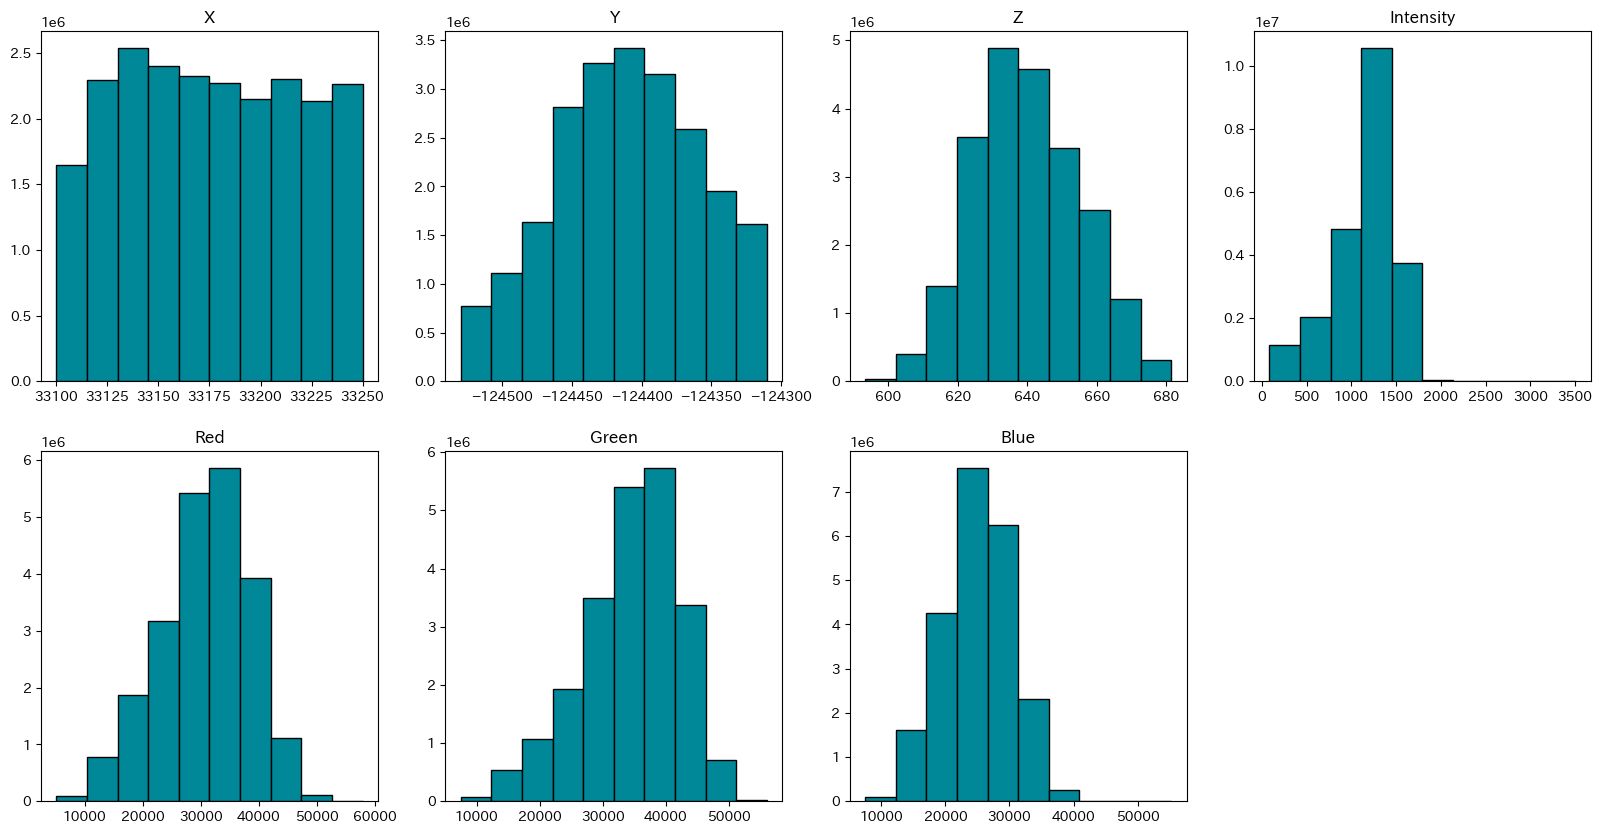

In [66]:
cols = ['X', 'Y', 'Z', 'Intensity', 'Red', 'Green', 'Blue']

fig = plt.figure(figsize=(20, 10))
for i, col in enumerate(cols):
    ax = fig.add_subplot(2, 4, i+1)
    ds = df[col].to_numpy()
    ax.hist(ds, fc='#008899', ec='black')
    ax.set_title(col)

plt.show()

# おわりに...
----
いかがだったでしょうか。このセッションではLidarデータの記録フォーマットである`.las`を使用して、`pdal`というライブラリを使った`pipeline`処理の流れや、実際のデータを見て見ました。次のセッションではDTM（数値地形モデル）作成などの、点群データのラスター化について解説していきます。
